# Chapter 04 - Training Models 

## Linear Regression

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

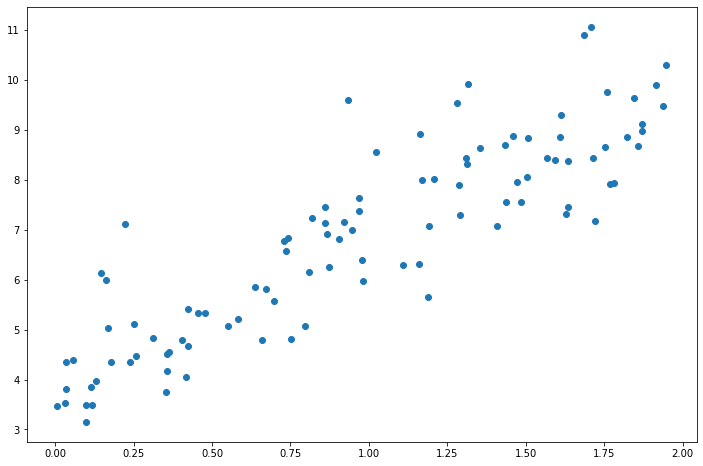

In [3]:
plt.figure(figsize = (12, 8))
plt.scatter(X, y)
plt.show()

Se ve el randomness... pero también se ve el efecto de la función lineal (más o menos y = 3X + 4)

In [4]:
# Cálculo de parámetros a mano
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[3.95698547],
       [2.9351006 ]])

Bastante bien... Casi 3 y casi 4

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.95698547],
       [9.82718667]])

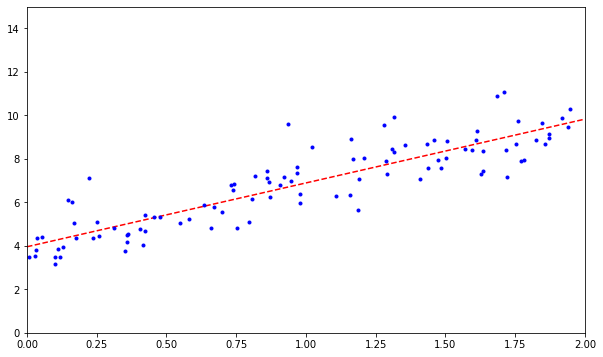

In [6]:
plt.figure(figsize = (10, 6))

plt.plot(X_new, y_predict, "r--")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Más o menos se ajusta bien

## Gradient Descent
La idea es tocar los parámetros de la función para minimizar la función costo

In [7]:
# gradient descent a manopla
eta = 0.1 # learning rate (greek letter eta)
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)  # random seed

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients  # Esta es la parte iterativa! Calcula theta nuevo a partir del paso anterior!

In [8]:
theta

array([[3.95698547],
       [2.9351006 ]])

#### Si cambio eta, cambian los ajustes.

### Stochastic Gradient Descent with learning schedule.

In [9]:
m = 100  # ???
n_epochs = 50  # Epochs to train
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)


theta = np.random.randn(2,1)  # random seed
for epoch in range(n_epochs):  # Una iteración
    for i in range(m):  # No entiendo bien qué es m ...
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        

In [10]:
theta

array([[3.94543311],
       [2.92587894]])

OK... SGD da parecido a BGD

SGD Linear Regression in sklearn

In [11]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [12]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.98883335]), array([2.97700322]))

OK. vemos que esta solución iterativa también converge a algo más o menos lógico

## Polynomial Regression

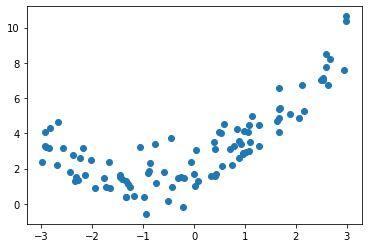

In [21]:
# Creo una ecacuión cuadrática
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)
plt.show()

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)  # Poly features (con degree = 2) agrega una segunda columna cuyo valor es el cuadrado de la feature original.

In [26]:
print(X[0])
print(X_poly[0])

[-0.45002757]
[-0.45002757  0.20252481]


In [27]:
# Ahora, con este dataset puedo fittear una regresión lineal:
from sklearn.linear_model import LinearRegression
poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_poly, y)
preds = poly_lin_reg.predict(X_poly)

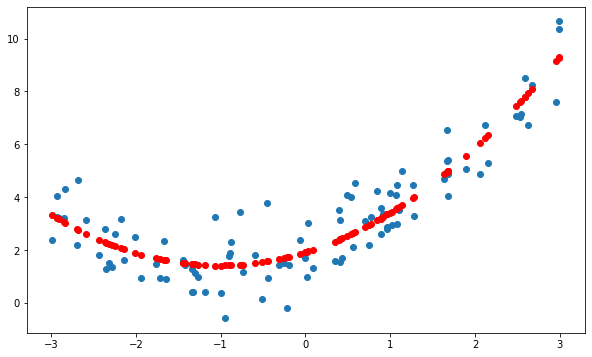

In [34]:
# plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.scatter(X, preds, c="red")
plt.show()

In [35]:
poly_lin_reg.intercept_, poly_lin_reg.coef_

(array([1.92215205]), array([[0.99794441, 0.48991984]]))

#### En el fondo es una regresión lineal! Lo que se está haciendo es fittear los coeficientes y la intercept. 
y = a x² + b x + c <br>
Lo que se hace es ajustar a, b y c. Es una ecuación lineal!

## Learning curves

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.figure(figsize=(10, 6))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.show()

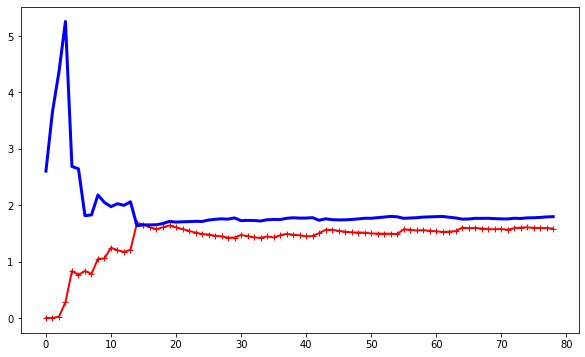

In [39]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

El modelo está underfitting. El modelo no puede generalizar bien. Tengo muchísimo error

#### idem para poly_reg

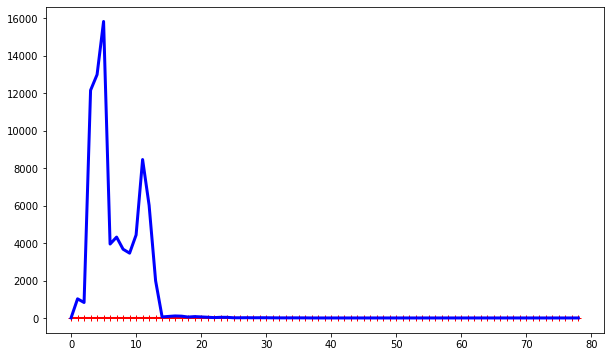

In [40]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
plot_learning_curves(polynomial_regression, X, y)

Acá no se ve! Ver ilustración de página 131

Veríamos curvas de un modelo que está overfitting. Principalmente porque se vería un gap entre el training error (rojo) y el testing error (azul)

# Regularization

## Ridge - Penalizes large thetas

In [42]:
# closed-form function: (MATRIX SOLVING, NO ITERATION)
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")  # Con alpha regulo qué tanto peso le doy al término de penalización
# alpha grande = mucho peso = thetas chicos. alpha chico = poco peso = thetas grandes (jajaja)

# SGD (iterative) solution
sgd_reg = SGDRegressor(penalty="l2")  # con penalty le estoy diciendo que le quiero agregar un término a la cost function. 
# hay una explicación de por qué es l2... pero bueno... l2 = Ridge

## Lasso - Penalizes large thetas, but linearly, not quadratically

In [43]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)  # same as Ridge. alpha regulates weight of penalty term in cost function.

## Elastic Net: mix de Lasso + Ridge

## Early stopping:
Otro approach a regularization

In [46]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.2)

# prepare the data
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty,
                       warm_start=True,  ## warm_start = True me permite seguir entrenando el modelo desde la última epoch que se entrenó. No tengo que empezar de 0
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

/home/panza/Desktop/Panza/Projects/virtual_envs/ho-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/panza/Desktop/Panza/Projects/virtual_envs/ho-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/panza/Desktop/Panza/Projects/virtual_envs/ho-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/panza/Desktop/Panza/Projects/virtual_envs/ho-ml/lib/python3.8/site-packages/sklearn/utils/validation

Bueno... saltó un warning, pero todo bien.

# Logistic Regression
Useful for Classification tasks!

In [50]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

In [51]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

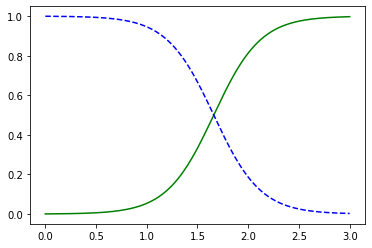

In [52]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

Ahí se ve la frontera de decisión!

# Softmax!